<a href="https://colab.research.google.com/github/lf2foce/quant/blob/master/iterrows_test_multiple_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'PyPortfolioOpt==1.2.3'

In [ ]:
!cp "/content/drive/My Drive/mylib.py" .

import mylib
vn30 = mylib.vn30()
vn30

In [ ]:
def vn30():
  index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
  index_price['Date'] = pd.to_datetime(index_price['Date'], format='%Y-%m-%d')
  vn30 = index_price[index_price['Ticker'] == 'VN30'][['Date', 'Close']].set_index('Date').rename(columns={'Close': 'VN30'})
  return vn30
vn30 = vn30()

In [ ]:
vn30_ticker

array(['BID', 'BVH', 'CTD', 'CTG', 'EIB', 'FPT', 'GAS', 'HDB', 'HPG',
       'MBB', 'MSN', 'MWG', 'NVL', 'PLX', 'PNJ', 'POW', 'REE', 'ROS',
       'SAB', 'SBT', 'SSI', 'STB', 'TCB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE'], dtype=object)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Ticker       Date     High      Low     Open    Close  AdjRatio  \
0    ACB 2014-01-02  15700.0  15600.0  15700.0  15700.0  1.973686   
1    ADC 2014-01-02  14700.0  14700.0  14700.0  14700.0  2.630399   
2    ALT 2014-01-02  12000.0  12000.0  12000.0  12000.0  1.456376   
3    AMC 2014-01-02  20000.0  20000.0  20000.0  20000.0  1.994956   
4    AME 2014-01-02   5700.0   5700.0   5700.0   5700.0  1.402778   

     TotalValue       Shares  Volume                        SectorL2  Year  \
0  2.309803e+09  921515369.0  147137                        Banks L2  2014   
1  5.880000e+06    1499985.0     400                        Media L2  2014   
2  0.000000e+00    4920398.0       0                        Media L2  2014   
3  0.000000e+00    2850000.0       0              Basic Resources L2  2014   
4  0.000000e+00   12000000.0       0  Industrial Goods & Services L2  2014   

      Adj_Close  Market_Capitalization  day  Quarter        Assets  \
0   7954.658964           7.330340e+12    2   

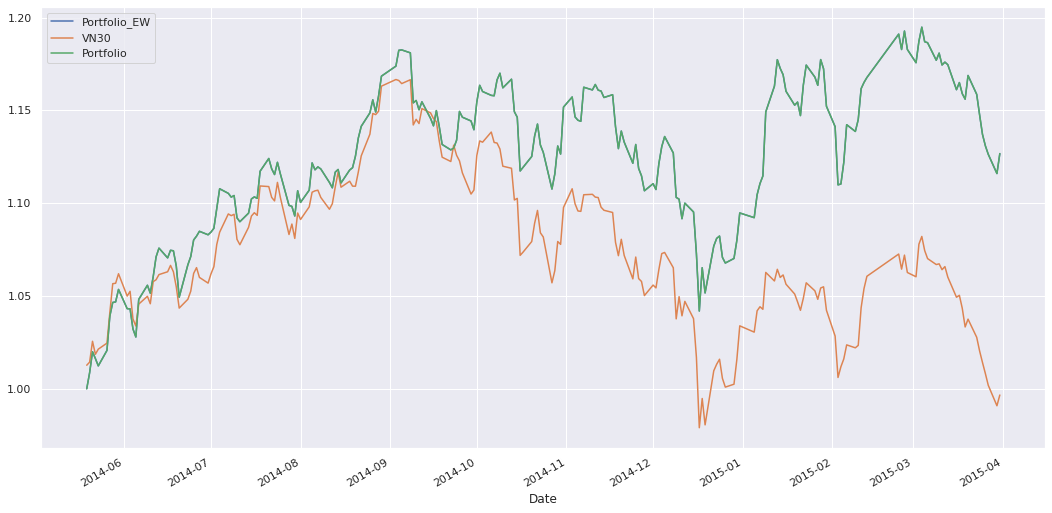

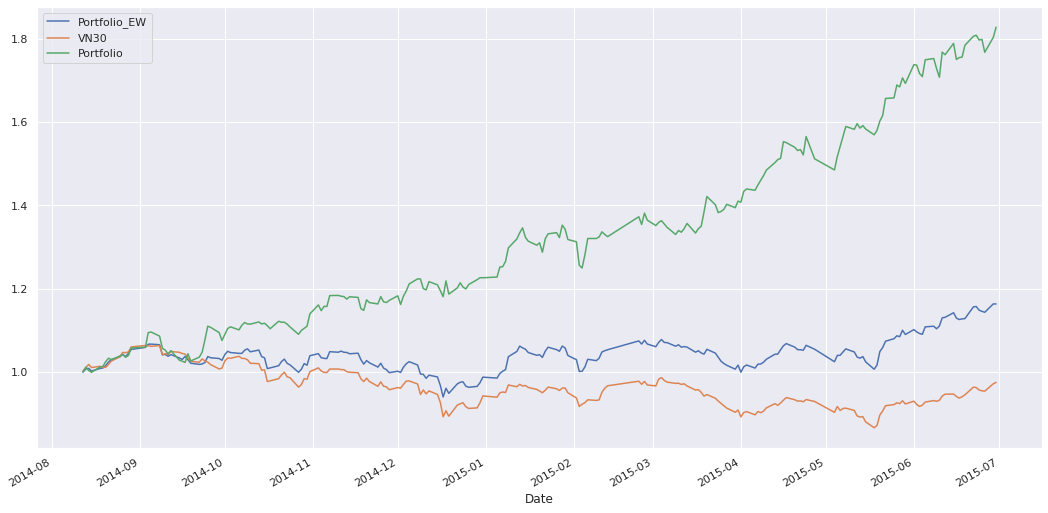

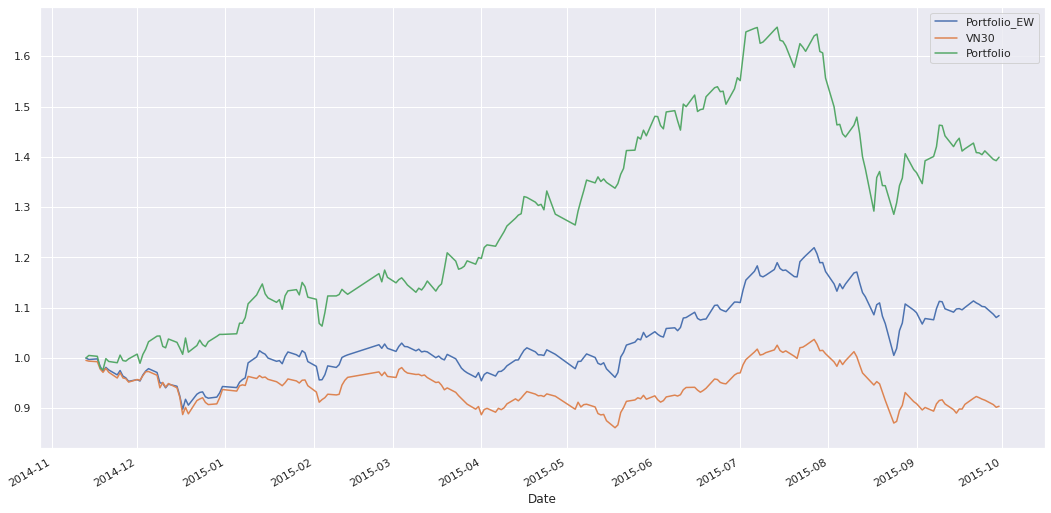

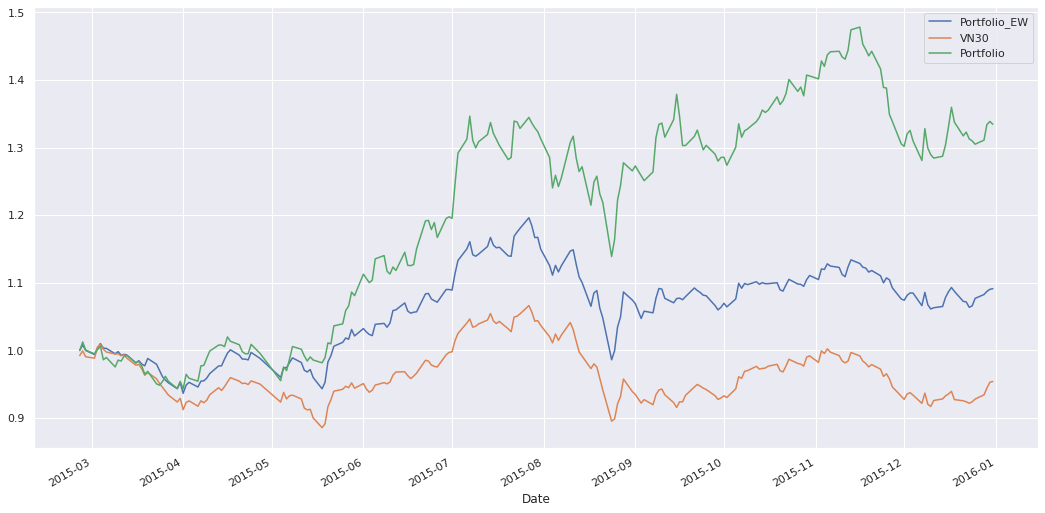

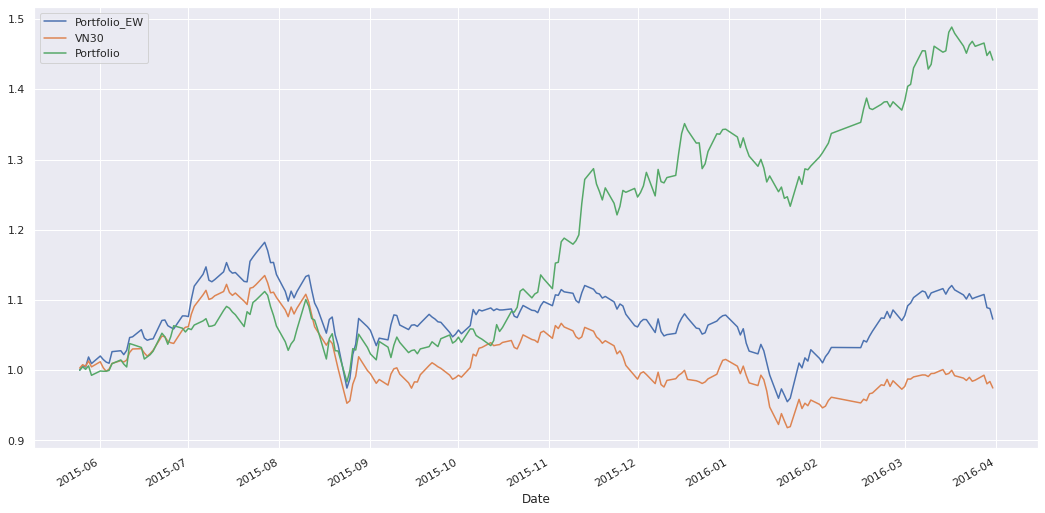

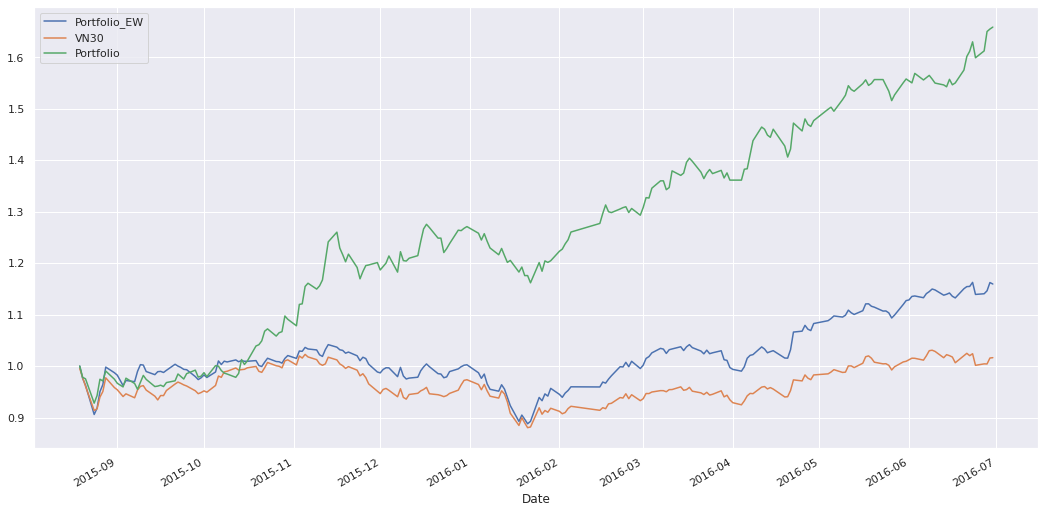

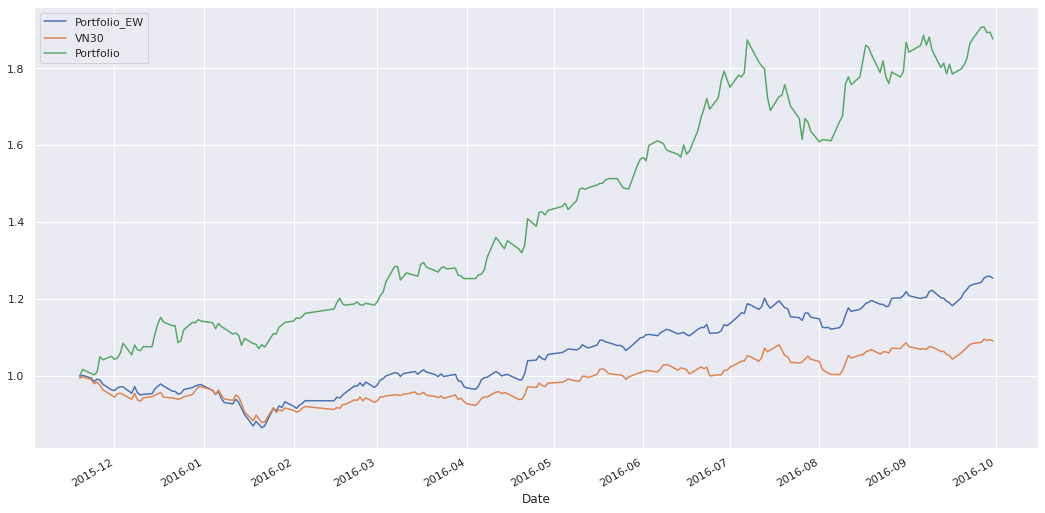

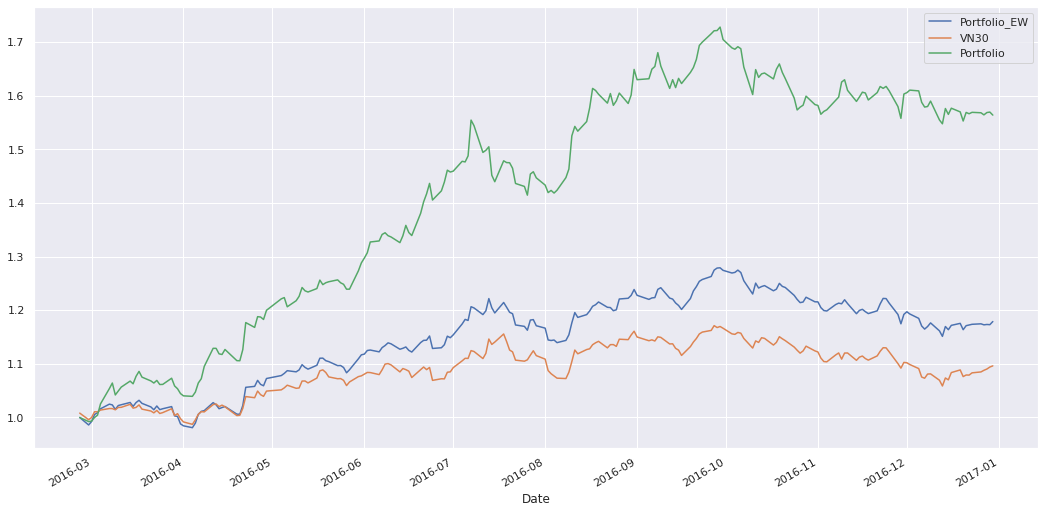

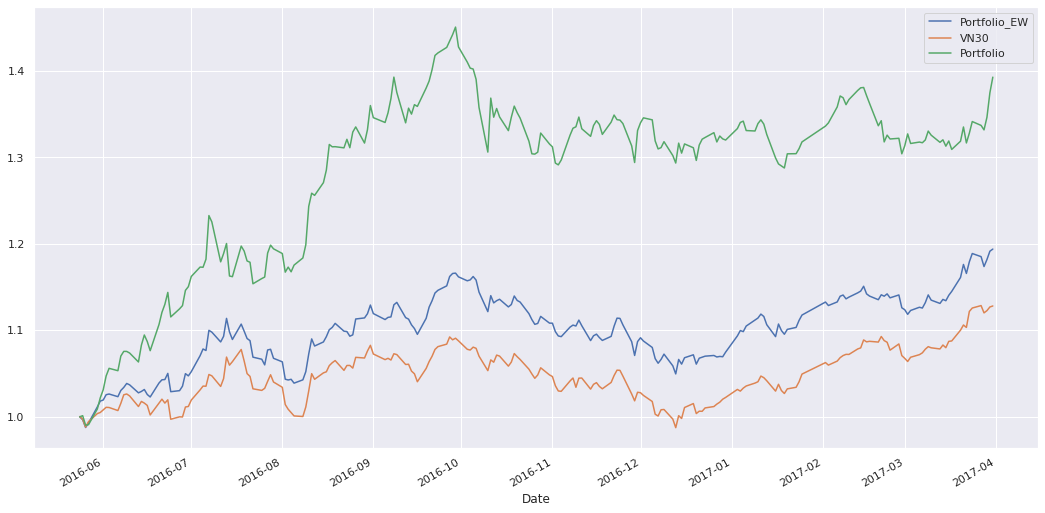

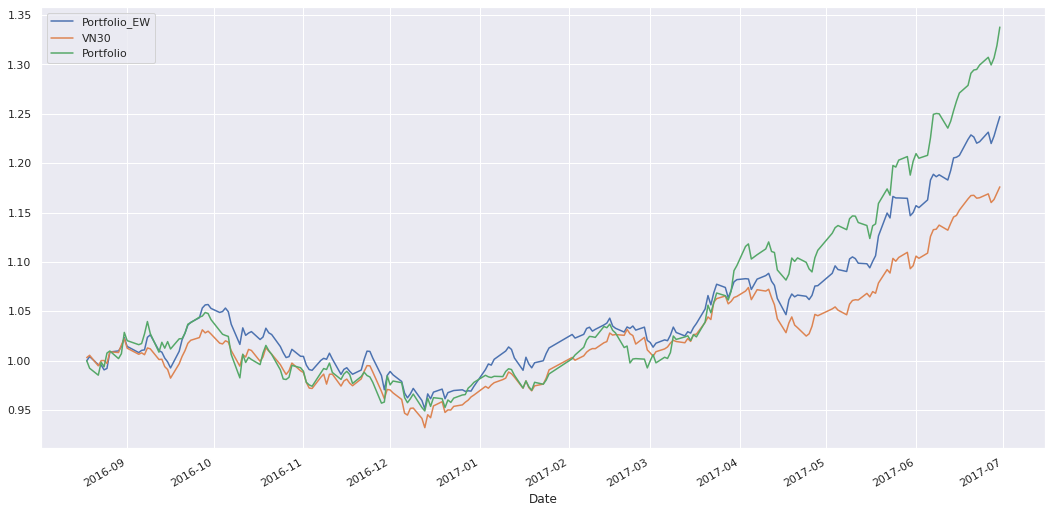

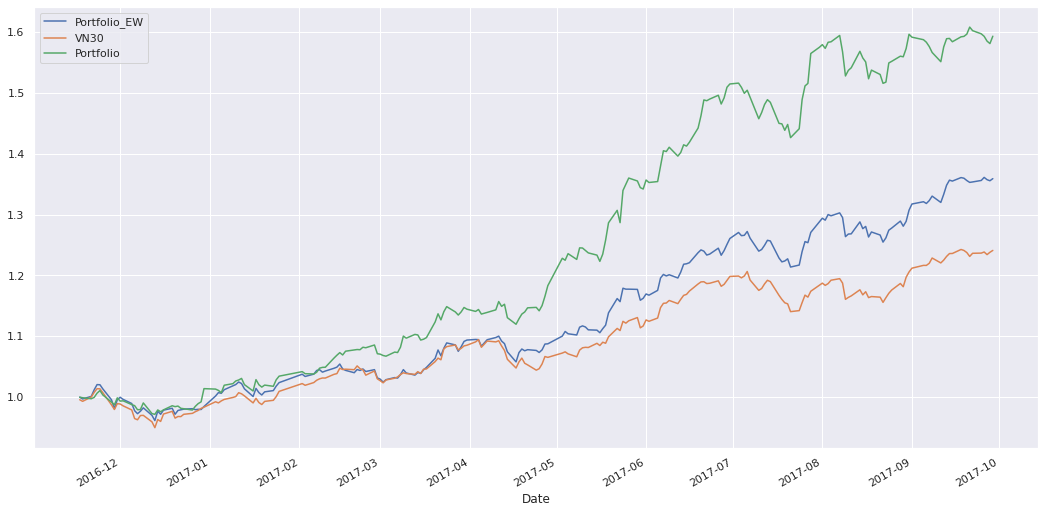

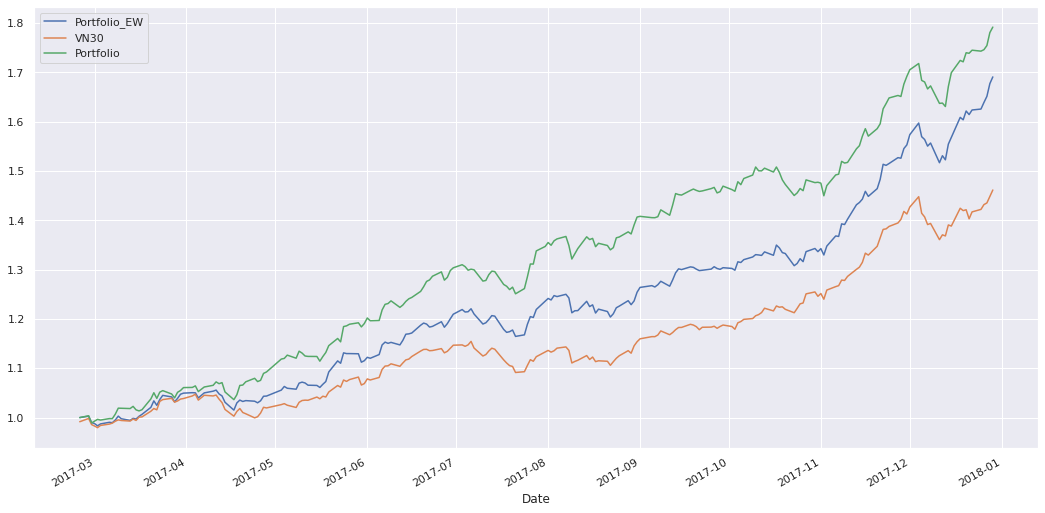

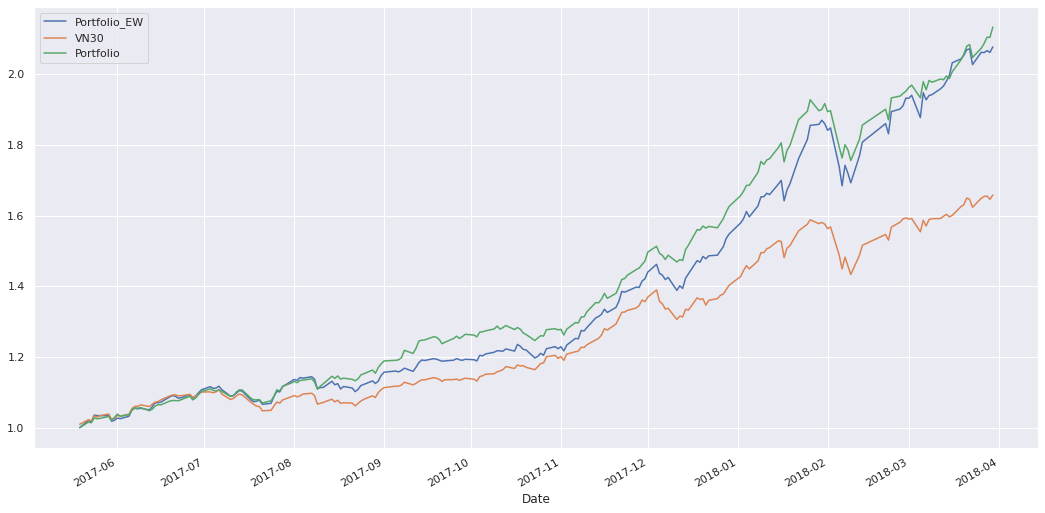

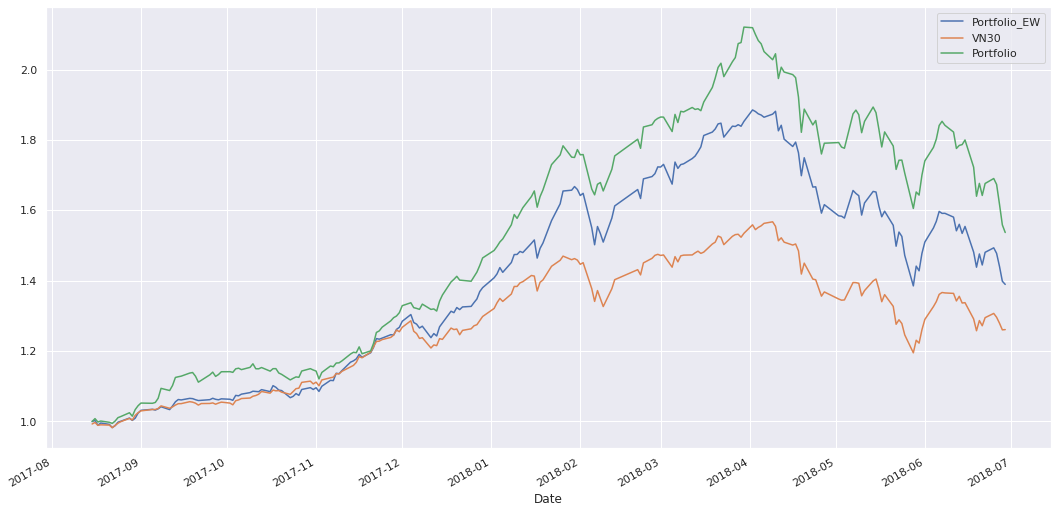

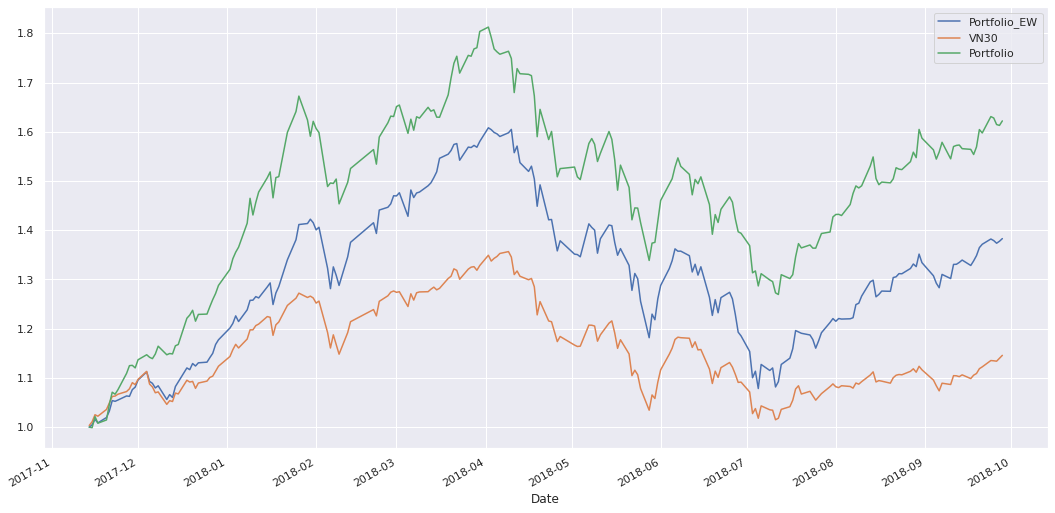

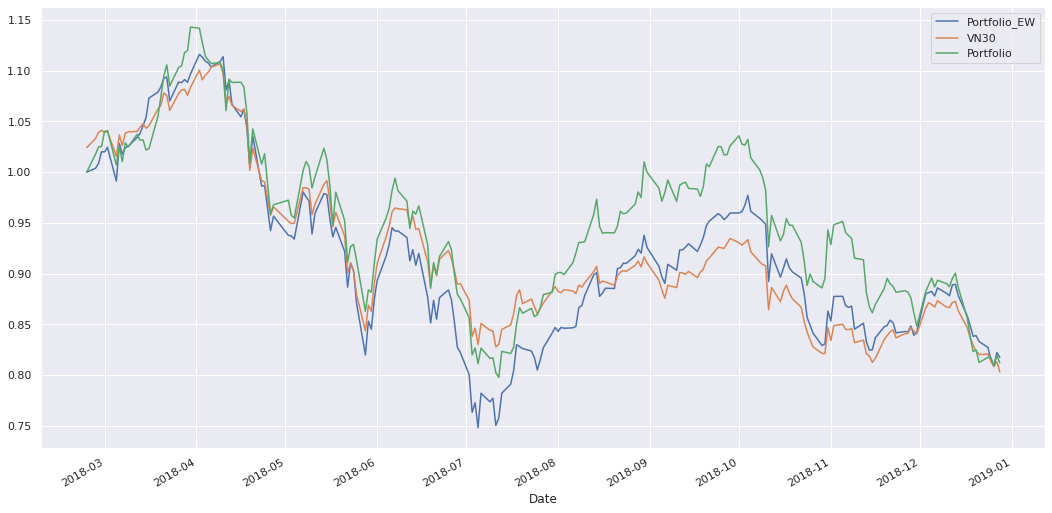

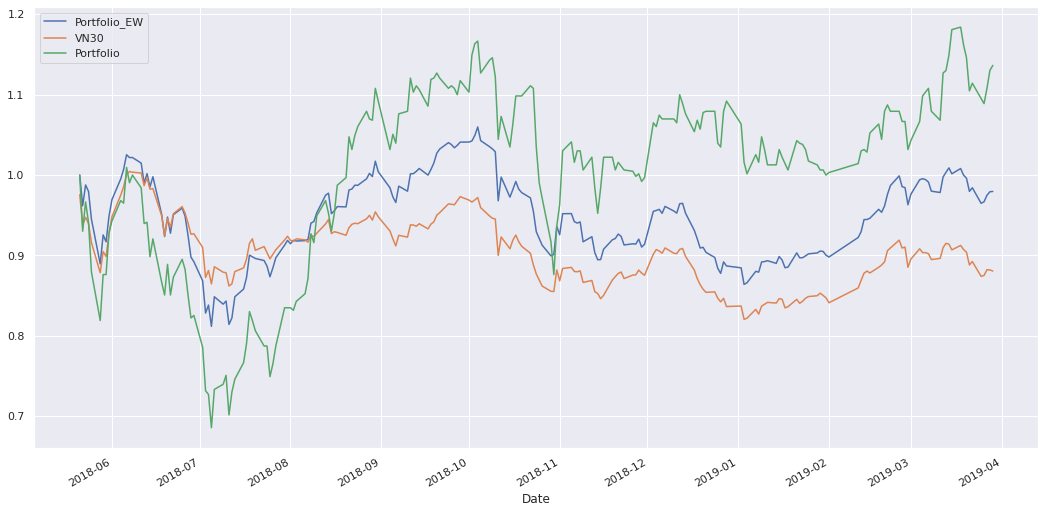

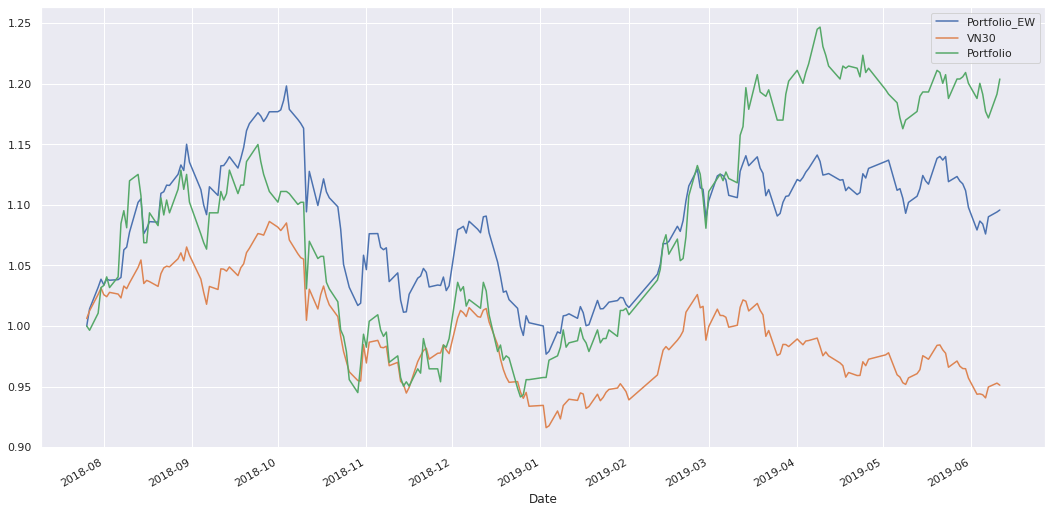

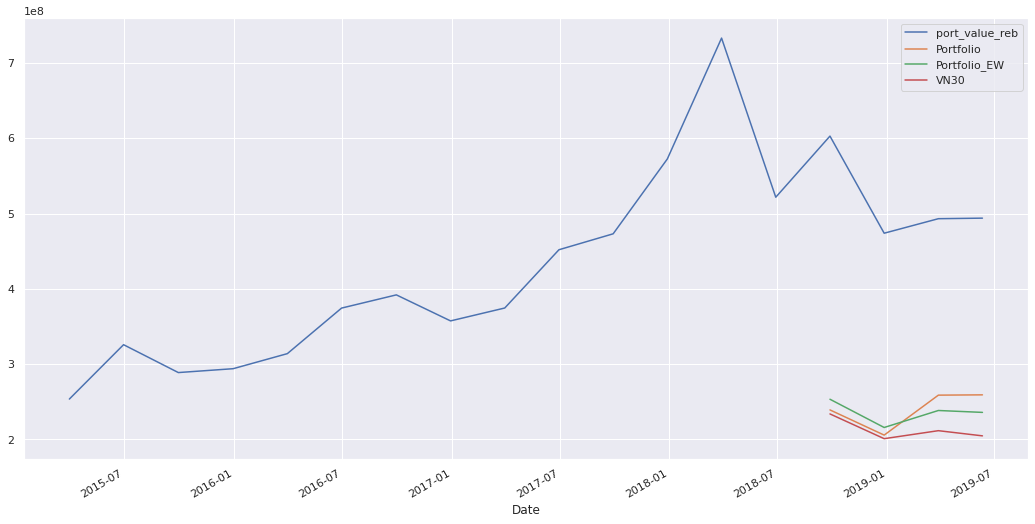

In [4]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


pd.set_option('display.max_columns', None)
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(18,9)})
# data timeframe
start_date = '2014-01-01'
end_date = '2019-09-28'

fav_sectors_L2_vi = ['Bán lẻ L2', 'Công nghệ Thông tin L2', 'Thực phẩm và đồ uống L2', 'Bất động sản L2', 'Ngân hàng L2', 'Y tế L2', 'Ô tô và phụ tùng L2', 'Du lịch và Giải trí L2' ]
fav_sectors_L2_en = ['Banks L2', 'Retail L2', 'Technology L2', 'Travel & Leisure L2', 'Health Care L2', 'Real Estate L2', 'Food & Beverage L2', 'Industrial Goods & Services L2', 'Basic Resources L2'  ]
#import csv & table ---------------------------------
data_index = pd.read_csv('/content/drive/My Drive/data_pricevolume06112019.csv')\
      [['Ticker', 'Date', 'High', 'Low', 'Open', 'Close', 'AdjRatio', 'TotalValue', 'Shares', 'Volume']]
vn30_ticker = pd.read_csv('/content/drive/My Drive/data_analyst/VN30_ticker.csv')
vn30_ticker = vn30_ticker['Ticker'].values
fundamental = pd.read_csv('/content/drive/My Drive/data_analyst/fundamental_data.csv')
sector_L2 = pd.read_csv('/content/drive/My Drive/data_analyst/sectorl2.csv')
data_index = pd.merge(data_index, sector_L2, on ='Ticker', how ='left' )

#chọn danh mục để tính toán
cal_stocks = ['VCB', 'HPG', 'FPT', 'VNM', 'PNJ', 'GAS', 'SSI', 'BID', 'MSN', 'MBB']  #POW NA
#cal_stocks = vn30_ticker

#filter & format
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index = data_index[ (data_index['Date'] >= start_date) & (data_index['Date'] <= end_date)  ]  #& (data_index.SectorL2.isin(fav_sectors_L2_en))
#add column
data_index['Year'] = data_index['Date'].apply(lambda x: x.year)
data_index['Adj_Close'] = data_index['Close'] / data_index['AdjRatio']
data_index['Market_Capitalization'] = data_index['Adj_Close'] * data_index['Shares']
#data_index['mcap_weight'] = data_index.groupby(['Date'])['Market_Capitalization'].apply(lambda x: x/(x.sum()))
data_index['day'] = data_index['Date'].dt.day
#data_index['quarter'] = data_index['Date'].apply(lambda x: str(x.year) + "Q" + str(x.quarter))
data_index['Quarter'] = data_index['Date'].dt.quarter
#merge fundamental
data_index = pd.merge(data_index, fundamental, on =['Ticker', 'Year', 'Quarter'], how ='left' )
data_index['EPS'] = data_index['NetIncome'] / data_index['Shares']
print(data_index.head())

data_index['quarter_end_date'] = data_index.groupby([data_index.Date.dt.year, data_index.Date.dt.quarter])['Date'].tail(1)

# quarter end date to rebalance weights
quarter_end_date_df = data_index[data_index.Date >= '2015-01'].quarter_end_date.dropna().reset_index(drop=True)
#quarter_end_date_list1 = data_index['quarter_end_date'].dt.date.unique().tolist()
#print(quarter_end_date_df.values)

data_index = data_index[data_index.Ticker.isin(cal_stocks)] #sau chon top10  đoạn này chưa chỉnh thời gian
data_index_pivot = data_index.pivot(columns='Ticker', index='Date', values='Adj_Close')

numstocks = len(cal_stocks)   #
#data_index = data_index.set_index('Date')
initial_cash= float(5000000.0)  #có phần này thì nên bỏ volume ra
initial_volume = 1000
total_reb_cost = 0.0
leftover_value = 0
# Set the initial capital  đang chưa linh hoạt chỗ này
initial_capital = (data_index[ (data_index['Date'] == data_index['Date'].min()) & (data_index.Ticker.isin(cal_stocks))].Adj_Close * initial_volume).sum()
print("Vốn đầu tư ban đầu 1000cp * 4 mã: " + str(initial_capital))

df_sosanh = pd.DataFrame(columns=['Date', 'port_value_reb'])
df_reblancing_all_time =  pd.DataFrame(columns=['Reb_date','Ticker', 'Adj_Close', 'current_volume', 'current_value', 'reb_weight',  'reb_volume', 'vol_change', 'buy/sell', 'value_change', 'reb_cost', 'Adj_value'])
for i in range(len(quarter_end_date_df)):
  df = data_index[data_index['Date'] <= quarter_end_date_df[i]][['Date', 'Ticker', 'Adj_Close']] 
  df = df[ df.Ticker.isin(cal_stocks) ]   #top10_highest_score_stock  cal_stocks đang có 4 mã
  df_pivot = df.pivot(columns='Ticker', index='Date', values='Adj_Close')
  df_pivot = df_pivot.iloc[-217:]  #tính weight dựa trên 217n trước đó min 217

  print(quarter_end_date_df[i])
  print("-----------------------------------------------------------ngày tái cơ cấu")
  # Expected returns and sample covariance
  mu = expected_returns.mean_historical_return(df_pivot)
  S = risk_models.sample_cov(df_pivot)

  # Optimise portfolio for maximum Sharpe Ratio
  ef = EfficientFrontier(mu, S)
  raw_weights = ef.max_sharpe()
  cleaned_weights = ef.clean_weights()
  print(cleaned_weights)
  print(raw_weights)
  ef.portfolio_performance(verbose=True, risk_free_rate=0.0)
  print("--------------------------------------------------end optimize calculation")

  weight_df = pd.DataFrame(cleaned_weights, columns =['Ticker', 'weight'])
  df_reblancing = df[df.Date == quarter_end_date_df[i]][['Ticker', 'Adj_Close']]

  # i==0 tức là KH đầu kỳ đã có 100 cp * n mã chứng khoán rồi tái cơ cấu lại kể từ kì 1
  if i == 0:
    df_reblancing['current_volume'] = initial_volume #last volume
  else: 
    df_reblancing['current_volume'] = volume_rb

  df_reblancing['current_value'] = df_reblancing['current_volume'] * df_reblancing['Adj_Close']
  df_reblancing['reb_weight'] = df_reblancing['current_value']/df_reblancing['current_value'].sum()
  total_portfolio_value_before_reb = df_reblancing['current_value'].sum()

  if i == 0:
    portfolio_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
  else: 
    portfolio_weights = np.array(df_reblancing['reb_weight'].to_list())

  # tính weight tối ưu
  latest_prices = df_reblancing.Adj_Close
  
  from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
  # tính volume tối ưu dựa trên weight tối ưu
  print(cleaned_weights)
  weights_rb = cleaned_weights 
  da = DiscreteAllocation(weights_rb, latest_prices, total_portfolio_value=total_portfolio_value_before_reb)
  allocation, leftover = da.lp_portfolio()
  print("Discrete allocation:", allocation)
  print("Funds remaining: VND{:.2f}".format(leftover))
  
  leftover_value = leftover_value + leftover
  weights_allocation_rebal = pd.DataFrame.from_dict(allocation, orient='index').reset_index()
  weights_allocation_rebal.columns=['Ticker', 'reb_volume']

  df_reblancing = df_reblancing.merge(weights_allocation_rebal, on='Ticker', how='left').fillna(0)
  df_reblancing['vol_change'] = df_reblancing['reb_volume'] - df_reblancing['current_volume']
  df_reblancing['buy/sell'] = df_reblancing['vol_change'].apply(lambda x: 'BUY' if x>0 else 'SELL')
  df_reblancing['value_change'] = df_reblancing['vol_change'] * df_reblancing['Adj_Close']
  df_reblancing['reb_cost'] = df_reblancing.apply(lambda row: row['value_change'] * 0.1/100 if row['buy/sell'] == 'BUY' else row['value_change'] * -0.2/100, axis=1 )
  df_reblancing['Adj_value'] = df_reblancing['reb_volume'] * df_reblancing['Adj_Close']
  total_reb_cost = total_reb_cost + df_reblancing['reb_cost'].sum()
  total_portfolio_value = df_reblancing['Adj_value'].sum()
  df_reblancing['Reb_date'] = quarter_end_date_df[i]
  volume_rb =  df_reblancing['reb_volume'].to_numpy()
  print(df_reblancing) #print chuan
  df_reblancing_all_time = pd.concat([df_reblancing_all_time, df_reblancing])
  print("Vốn đầu tư tại thời điểm hiện tại: " + str(total_portfolio_value))
  print("------------------------------------------------------------so sánh hiệu suất")


  returns = df_pivot.pct_change()           #dropNA phải để ý
  exp_return_d = returns.mean()
  cov_matrix_a = returns.cov() *252   #cov year

  #portfolio_weights_mcap = df[df.Date == quarter_end_date_df[i]].mcap_weight.to_numpy() #co the sai thu tu, đang có vấn đề
  portfolio_weights_ew = np.repeat(1/numstocks, numstocks)   # Benchmark 1/n strategy

  #portfolio_weights = np.array([0.4, 0.2, 0.1, 0.3])
  #statistics weight cho truoc
  portfolio_return_a = round(np.sum(exp_return_d * portfolio_weights) * 252,5)
  portfolio_std_dev = round(np.sqrt(np.dot(portfolio_weights.T,np.dot(cov_matrix_a, portfolio_weights))) ,5)
  #statistics equal weight 
  portfolio_return_ew = round(np.sum(exp_return_d * portfolio_weights_ew) * 252,5)
  portfolio_std_dev_ew = round(np.sqrt(np.dot(portfolio_weights_ew.T,np.dot(cov_matrix_a, portfolio_weights_ew))) ,5)
  
  returns['Portfolio'] = returns.mul(portfolio_weights, axis=1).sum(axis=1)
  returns['Portfolio_EW'] =  returns.iloc[:, 0:numstocks].mul(portfolio_weights_ew, axis=1).sum(axis=1)
  #returns['Portfolio_MCap'] = returns.iloc[:, 0:numstocks].mul(portfolio_weights_mcap, axis=1).sum(axis=1)

  returns = pd.merge(returns, vn30.pct_change(), on =['Date'], how ='left' )#[['Ticker', 'Adj_Close']] #, 'Close']].rename(columns={'Close': 'VN30'})
  #CummulativeReturns = (1+ returns).cumprod() - 1
  CummulativeReturns = (1+ returns).cumprod() # k cần trừ vì tính value hiện tại
  #df = df.join(vn30_pivot_return.loc[:, "VN30"]).rename(columns={"VN30": "Benchmark"})  # k dùng, snip tạm để
  
  #CummulativeReturns[["Portfolio", "Portfolio_EW", 'Portfolio_MCap', 'Benchmark']].plot()  #
  CummulativeReturns[["Portfolio_EW", 'VN30', "Portfolio"]].plot()
  CummulativeReturns_sil = CummulativeReturns.iloc[:, numstocks:]  * initial_capital
  df_sosanh = df_sosanh.append({'Date': quarter_end_date_df[i], 'port_value_reb': total_portfolio_value}, ignore_index=True)
  #CummulativeReturns_sil.plot()
  print(CummulativeReturns_sil)
  print(df_sosanh)
  
  #print("Expected annualized return: " + str(portfolio_return_a))
  #print("Standard deviation (Volatility): " + str(portfolio_std_dev))
  #print("portfolio sharpe " + str(np.round(portfolio_return_a/portfolio_std_dev, 4) ))
  print("vs  ")
  print("Expected annualized return ew: " + str(portfolio_return_ew))
  print("Standard deviation (Volatility) ew: " + str(portfolio_std_dev_ew))
  print("portfolio sharpe ew " + str(np.round(portfolio_return_ew/portfolio_std_dev_ew, 4) ))
  print("============================================================================end of each iter")

print("--------------------grand total cost")
print("amount cost to rebalance " + str(total_reb_cost))
cummulative_capital = initial_cash + total_portfolio_value + leftover_value - total_reb_cost

print("amount invested + cash " + str(initial_cash + initial_capital))
print("total return after cost & taxt " + str(cummulative_capital))
#print("total return if holding  " + str(CummulativeReturns.Portfolio_EW.tail(1)))
df_sosanh= df_sosanh.merge(CummulativeReturns_sil, on='Date', how='left')
print(df_sosanh)
df_sosanh.set_index('Date').plot() # secondary_y = ["Portfolio_EW", 'Benchmark']
df_reblancing_all_time.to_csv('test.csv')

In [ ]:
eps_df = data_index[['Ticker', 'Quarter', 'Year', 'NetIncome', 'EPS']].drop_duplicates()
eps_df['quarterly_growth'] = eps_df.groupby(['Ticker'])['EPS'].pct_change()
eps_df.head(15)

In [ ]:
class TickData(object):
	""" Stores a single unit of data """

	def __init__(self, timestamp='', symbol='',
				open_price=0, close_price=0, total_volume=0):
		self.symbol = symbol
		self.timestamp = timestamp
		self.open_price = open_price
		self.close_price = close_price
		self.total_volume = total_volume

In [ ]:
class MarketData(object):
	def __init__(self):
		self.recent_ticks = dict()  # indexed by symbol

	def add_tick_data(self, tick_data):
		self.recent_ticks[tick_data.symbol] = tick_data

	def get_open_price(self, symbol):
		return self.get_tick_data(symbol).open_price

	def get_close_price(self, symbol):
		return self.get_tick_data(symbol).close_price

	def get_tick_data(self, symbol):
		return self.recent_ticks.get(symbol, TickData())

	def get_timestamp(self, symbol):
		return self.recent_ticks[symbol].timestamp

In [ ]:
#test từng function
pd.set_option('display.max_columns', None)
#symbol = 'WIKI/AAPL'
symbol = ['VCB']
start='2017-01-01'
end='2017-12-31'

def fetch_historical_prices(symbol, start_date, end_date):
    #df = data_index[(data_index['Ticker'].isin(symbol)) & (data_index['Date'] > start_date) & (data_index['Date'] < end_date) ]
    df = data_index[(data_index['Ticker'].isin(symbol))] 
    #df = data_index[(data_index['Ticker'] == self.symbol] 
    df = df.loc[start_date: end_date]
    return df
print(fetch_historical_prices(symbol, start, end))

#ben duoi chuan het, test thử 
#print(data_index)
#quarter_end_date_df = data_index.quarter_end_date.dropna().loc['2012-02':].reset_index(drop=True)
#quarter_end_date_df.set_index('Date')
#quarter_end_date_df.columns = 'Date'
#quarter_end_date_df
#quarter_end_date_df_1 = quarter_end_date_df.loc['2018-06-29']
#quarter_end_date_df_1
data_index1 = data_index[data_index.Date >= '2019-01']
print(data_index1)

Empty DataFrame
Columns: [Ticker, Date, High, Low, Open, Close, AdjRatio, TotalValue, Shares, Volume, SectorL2, Year, Adj_Close, Market_Capitalization, mcap_weight, day, quarter, quarter_end_date]
Index: []
        Ticker       Date      High       Low      Open     Close  AdjRatio  \
2240859    BID 2019-01-02   34400.0   33450.0   34400.0   33500.0  1.034314   
2240867    BVH 2019-01-02   90900.0   89000.0   90900.0   89000.0  1.013793   
2240892    CTD 2019-01-02  160000.0  158000.0  159600.0  160000.0  1.031250   
2240894    CTG 2019-01-02   19450.0   19000.0   19250.0   19000.0  1.000000   
2240930    EIB 2019-01-02   14100.0   14000.0   14000.0   14000.0  1.000000   
...        ...        ...       ...       ...       ...       ...       ...   
2405944    VIC 2019-06-11  117800.0  117000.0  117600.0  117000.0  1.000000   
2405948    VJC 2019-06-11  124200.0  122800.0  123600.0  124000.0  1.000000   
2405954    VNM 2019-06-11  127000.0  125400.0  127000.0  125500.0  1.025342   
240

In [ ]:
#symbol = ['VCB']
#start='2017-01-01'
#end='2017-12-31'

class MarketDataSource(object):
    def __init__(self, symbol, tick_event_handler=None, start='', end=''):
        self.market_data = MarketData()

        self.symbol = symbol
        self.tick_event_handler = tick_event_handler
        self.start, self.end = start, end
        self.df = None

    def fetch_historical_prices(self):
        #df = data_index[(data_index['Ticker'].isin(self.symbol))] 
        df = data_index[ data_index['Ticker'] == self.symbol ]
        df = df.loc[self.start: self.end]
        return df


    def run(self):
        if self.df is None:
            self.df = self.fetch_historical_prices()

        total_ticks = len(self.df)
        print('Processing total_ticks:', total_ticks)

        for timestamp, row in self.df.iterrows():
            open_price = row['Open']
            close_price = row['Close']
            volume = row['Volume']

            print(timestamp.date(), 'TICK', self.symbol,
                  'open:', open_price,
                  'close:', close_price)
            tick_data = TickData(timestamp, self.symbol, open_price,
                                close_price, volume)
            self.market_data.add_tick_data(tick_data)

            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)
#audi = MarketDataSource(symbol, start='2016-01-01', end='2017-12-31')
#audi.fetch_historical_prices()

In [ ]:
class Order(object):
	def __init__(self, timestamp, symbol, 
		qty, is_buy, is_market_order, 
		price=0
	):
		self.timestamp = timestamp
		self.symbol = symbol
		self.qty = qty
		self.price = price
		self.is_buy = is_buy
		self.is_market_order = is_market_order
		self.is_filled = False
		self.filled_price = 0
		self.filled_time = None
		self.filled_qty = 0

In [ ]:
class Position(object):
	def __init__(self, symbol=''):
		self.symbol = symbol
		self.buys = self.sells = self.net = 0
		self.rpnl = 0 #recently realized profits and losses
		self.position_value = 0  #securities is credit into this acct

	def on_position_event(self, is_buy, qty, price):
		if is_buy:
			self.buys += qty
		else:
			self.sells += qty

		self.net = self.buys - self.sells
		changed_value = qty * price * (-1 if is_buy else 1)
		self.position_value += changed_value

		if self.net == 0:
			self.rpnl = self.position_value
			self.position_value = 0

	def calculate_unrealized_pnl(self, price):
		if self.net == 0:
			return 0

		market_value = self.net * price
		upnl = self.position_value + market_value
		return upnl

In [ ]:
from abc import abstractmethod

class Strategy:
	def __init__(self, send_order_event_handler):
		self.send_order_event_handler = send_order_event_handler

	@abstractmethod
	def on_tick_event(self, market_data):
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def on_position_event(self, positions):
		raise NotImplementedError('Method is required!')

	def send_market_order(self, symbol, qty, is_buy, timestamp):
		if self.send_order_event_handler:
			order = Order(
				timestamp,
				symbol,
				qty,
				is_buy,
				is_market_order=True,
				price=0,
			)
			self.send_order_event_handler(order)

In [ ]:
import pandas as pd

class MeanRevertingStrategy(Strategy):
    def __init__(self, symbol, trade_qty,
        send_order_event_handler=None, lookback_intervals=20,
        buy_threshold=-1.5, sell_threshold=1.5
    ):
        super(MeanRevertingStrategy, self).__init__(
            send_order_event_handler)

        self.symbol = symbol
        self.trade_qty = trade_qty
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

        self.prices = pd.DataFrame()
        self.is_long = self.is_short = False

    def on_position_event(self, positions):
        position = positions.get(self.symbol)

        self.is_long = position and position.net > 0
        self.is_short = position and position.net < 0

    def on_tick_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.lookback_intervals:
            return

        self.generate_signals_and_send_order(market_data)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        close_price = market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp, 'close'] = close_price

    def generate_signals_and_send_order(self, market_data):
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)

        if self.buy_threshold > signal_value and not self.is_long:
            print(timestamp.date(), 'BUY signal')
            self.send_market_order(
                self.symbol, self.trade_qty, True, timestamp)
        elif self.sell_threshold < signal_value and not self.is_short:
            print(timestamp.date(), 'SELL signal')
            self.send_market_order(
                self.symbol, self.trade_qty, False, timestamp)

    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices['close'].pct_change().dropna()
        z_score = ((returns - returns.mean()) / returns.std())[-1]
        return z_score

In [ ]:
class BacktestEngine:
	def __init__(self, symbol, trade_qty, start='', end=''):
		self.symbol = symbol
		self.trade_qty = trade_qty
		self.market_data_source = MarketDataSource(
			symbol,
			tick_event_handler=self.on_tick_event,
			start=start, end=end
		)

		self.strategy = None
		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = None
        
	def start(self, **kwargs):
		print('Backtest started...')

		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = pd.DataFrame()

		self.strategy = MeanRevertingStrategy(
			self.symbol,
			self.trade_qty,
			send_order_event_handler=self.on_order_received,
			**kwargs
		)
		self.market_data_source.run()

		print('Backtest completed.')
        
	def on_order_received(self, order):
		""" Adds an order to the order book """
		print(
			order.timestamp.date(),
			'ORDER',
			'BUY' if order.is_buy else 'SELL',
			order.symbol,
			order.qty
		)
		self.unfilled_orders.append(order)
        
	def on_tick_event(self, market_data):
		self.match_order_book(market_data)
		self.strategy.on_tick_event(market_data)
		self.print_position_status(market_data)
        
	def match_order_book(self, market_data):
		if len(self.unfilled_orders) > 0:
			self.unfilled_orders = [
				order for order in self.unfilled_orders
				if self.match_unfilled_orders(order, market_data)
			]
            
	def match_unfilled_orders(self, order, market_data):
		symbol = order.symbol
		timestamp = market_data.get_timestamp(symbol)

		""" Order is matched and filled """
		if order.is_market_order and timestamp > order.timestamp:
			open_price = market_data.get_open_price(symbol)

			order.is_filled = True
			order.filled_timestamp = timestamp
			order.filled_price = open_price

			self.on_order_filled(
				symbol, order.qty, order.is_buy,
				open_price, timestamp
			)
			return False

		return True
    
	def on_order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
		position = self.get_position(symbol)
		position.on_position_event(is_buy, qty, filled_price)
		self.df_rpnl.loc[timestamp, "rpnl"] = position.rpnl

		self.strategy.on_position_event(self.positions)

		print(
			timestamp.date(),
			'FILLED', "BUY" if is_buy else "SELL",
			qty, symbol, 'at', filled_price
		)
        
	def get_position(self, symbol):
		if symbol not in self.positions:
			self.positions[symbol] = Position(symbol)

		return self.positions[symbol]
    
	def print_position_status(self, market_data):
		for symbol, position in self.positions.items():
			close_price = market_data.get_close_price(symbol)
			timestamp = market_data.get_timestamp(symbol)

			upnl = position.calculate_unrealized_pnl(close_price)

			print(
				timestamp.date(),
				'POSITION',
				'value:%.3f' % position.position_value,
				'upnl:%.3f' % upnl,
				'rpnl:%.3f' % position.rpnl
			)

In [ ]:
engine = BacktestEngine(
    'VCB', 1000,
    start='2015-01-01',
    end='2017-12-31'
)

In [ ]:
engine.start(
    lookback_intervals=20,
    buy_threshold=-1.5,
    sell_threshold=1.5
)

Backtest started...
Processing total_ticks: 1


AttributeError: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

engine.df_rpnl.plot(figsize=(12, 8));

In [ ]:

def fetch_historical_prices(symbol, start, end):
    import quandl

    # Update your Quandl API key here...
    QUANDL_API_KEY = 'vfB6Ln8TQsxweRFnn89J'
    quandl.ApiConfig.api_key = QUANDL_API_KEY
    df = quandl.get(symbol, start_date=start, end_date=end)
    return df
fetch_historical_prices('WIKI/AAPL', start='2015-01-01',
    end='2017-12-31')    

In [ ]:
#cal_stocks = ['VCB', 'HPG', 'FPT', 'VNM'] 
#weights_allocation_rebal

#df_reblancing['current_weight']
#a = df_reblancing['current_weight']

#a.to_list()

df_reblancing_all_time.to_csv('test.csv')
quarter_end_date_df[1]
df_reblancing['test'] = quarter_end_date_df[1]
df_reblancing
raw_weights

OrderedDict([('BID', 0.1603956138903293),
             ('FPT', 0.5354346561919078),
             ('GAS', 0.1615157497471128),
             ('HPG', 0.0),
             ('MBB', 0.0),
             ('MSN', 0.0),
             ('PNJ', 0.0),
             ('SSI', 0.0),
             ('VCB', 0.1426539801706502),
             ('VNM', 0.0)])